# Clustering Case Study: Customer Segmentation with K-Means -  Tier 3
***
This case study is based on [this blog post](http://blog.yhat.com/posts/customer-segmentation-using-python.html) by the `yhat` blog. Please feel free to refer to the post for additional information, and solutions.

Structure of the mini-project:

1. **Sourcing and loading**
    * Load the data
    * Explore the data


2. **Cleaning, transforming and visualizing**
    * Data Wrangling: Exercise Set 1
        - Creating a matrix with a binary indicator for whether they responded to a given offer
        - Ensure that in doing so, NAN values are dealt with appropriately
    

3. **Modelling** 
    * K-Means clustering: Exercise Sets 2 and 3
        - Choosing K: The Elbow method
        - Choosing K: The Silhouette method
        - Choosing K: The Gap statistic method
    
    * Visualizing clusters with PCA: Exercise Sets 4 and 5


4. **Conclusions and next steps**
    * Conclusions
    * Other clustering algorithms (Exercise Set 6)

In [1]:
%matplotlib inline
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import seaborn as sns
import numpy as np

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

from sklearn.decomposition import PCA

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

## 1. Sourcing and loading
### 1a. Load the data
The dataset contains information on marketing newsletters/e-mail campaigns (e-mail offers sent to customers) and transaction level data from customers. The transactional data shows which offer customers responded to, and what the customer ended up buying. The data is presented as an Excel workbook containing two worksheets. Each worksheet contains a different dataset.

In [2]:
df_offers = pd.read_excel("./WineKMC.xlsx", sheet_name=0)

/Users/rossbrinkerhoff/opt/anaconda3/envs/Springboard_Second_Capstone/lib/python3.9/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


### 1b. Explore the data

In [3]:
df_offers.columns = ["offer_id", "campaign", "varietal", "min_qty", "discount", "origin", "past_peak"]
df_offers.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
2,3,February,Espumante,144,32,Oregon,True
3,4,February,Champagne,72,48,France,True
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True


We see that the first dataset contains information about each offer such as the month it is in effect and several attributes about the wine that the offer refers to: the variety, minimum quantity, discount, country of origin and whether or not it is past peak. The second dataset in the second worksheet contains transactional data -- which offer each customer responded to.

In [4]:
df_transactions = pd.read_excel("./WineKMC.xlsx", sheet_name=1)
df_transactions.columns = ["customer_name", "offer_id"]
df_transactions['n'] = 1
df_transactions.head()

/Users/rossbrinkerhoff/opt/anaconda3/envs/Springboard_Second_Capstone/lib/python3.9/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


,customer_name,offer_id,n
0,Smith,2,1
1,Smith,24,1
2,Johnson,17,1
3,Johnson,24,1
4,Johnson,26,1


## 2. Cleaning, transforming and visualizing
### 2a. Data Wrangling

We're trying to learn more about how our customers behave, so we can use their behavior (whether or not they purchased something based on an offer) as a way to group similar minded customers together. We can then study those groups to look for patterns and trends which can help us formulate future offers.

The first thing we need is a way to compare customers. To do this, we're going to create a matrix that contains each customer and a 0/1 indicator for whether or not they responded to a given offer. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set I</h3>

<p><b>Exercise:</b> Create a data frame where each row has the following columns (Use the pandas [`merge`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html) and [`pivot_table`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.pivot_table.html) functions for this purpose):
<ul>
<li> customer_name
<li> One column for each offer, with a 1 if the customer responded to the offer
</ul>
<p>Make sure you also deal with any weird values such as `NaN`. Read the documentation to develop your solution.</p>
</div>

In [5]:
#your turn

df_merged = df_transactions.merge(df_offers, on = 'offer_id')

In [6]:
cols_to_drop = ['campaign','varietal','min_qty','discount','origin','past_peak']
df_merged.drop(columns=cols_to_drop, inplace = True)

In [7]:
df_merged.head()

,customer_name,offer_id,n
0,Smith,2,1
1,Smith,24,1
2,Johnson,17,1
3,Johnson,24,1
4,Johnson,26,1


In [8]:
df_pivot = df_merged.pivot_table(index ='customer_name',columns = 'offer_id',values = 'n', fill_value = 0 )
df_pivot.head()

offer_id,1,2,3,4,5,6,7,8,9,10,...,23,24,25,26,27,28,29,30,31,32
customer_name,,,,,,,,,,,,,,,,,,,,,
Adams,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
Allen,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
Anderson,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
Bailey,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
Baker,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## 3. Modelling 
### 3a. K-Means Clustering

Recall that in K-Means Clustering we want to *maximize* the distance between centroids and *minimize* the distance between data points and the respective centroid for the cluster they are in. True evaluation for unsupervised learning would require labeled data; however, we can use a variety of intuitive metrics to try to pick the number of clusters K. We will introduce two methods: the Elbow method, the Silhouette method and the gap statistic.

#### 3ai. Choosing K: The Elbow Sum-of-Squares Method

The first method looks at the sum-of-squares error in each cluster against $K$. We compute the distance from each data point to the center of the cluster (centroid) to which the data point was assigned. 

$$SS = \sum_k \sum_{x_i \in C_k} \sum_{x_j \in C_k} \left( x_i - x_j \right)^2 = \sum_k \sum_{x_i \in C_k} \left( x_i - \mu_k \right)^2$$

where $x_i$ is a point, $C_k$ represents cluster $k$ and $\mu_k$ is the centroid for cluster $k$. We can plot SS vs. $K$ and choose the *elbow point* in the plot as the best value for $K$. The elbow point is the point at which the plot starts descending much more slowly. 

**Hint:** the Elbow Method is discussed in part 2 of the Harvard Clustering lecture. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set II</h3>

<p><b>Exercise:</b></p> 
<ul>
<li> What values of $SS$ do you believe represent better clusterings? Why?
<li> Create a numpy matrix `x_cols` with only the columns representing the offers (i.e. the 0/1 colums) 
<li> Write code that applies the [`KMeans`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) clustering method from scikit-learn to this matrix. 
<li> Construct a plot showing $SS$ for each $K$ and pick $K$ using this plot. For simplicity, test $2 \le K \le 10$.
<li> Make a bar chart showing the number of points in each cluster for k-means under the best $K$.
<li> What challenges did you experience using the Elbow method to pick $K$?
</ul>
</div>

In [9]:
# your turn

In [10]:
x_cols = df_pivot.reset_index(drop=True)
x_cols.head()

offer_id,1,2,3,4,5,6,7,8,9,10,...,23,24,25,26,27,28,29,30,31,32
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [11]:
sum_of_squares_data = []
num_points = []

for i in range(1,11):
    model = KMeans(n_clusters = i,n_init = 'auto',random_state=42)
    model.fit(x_cols)
    sum_of_squares_data.append(model.inertia_)

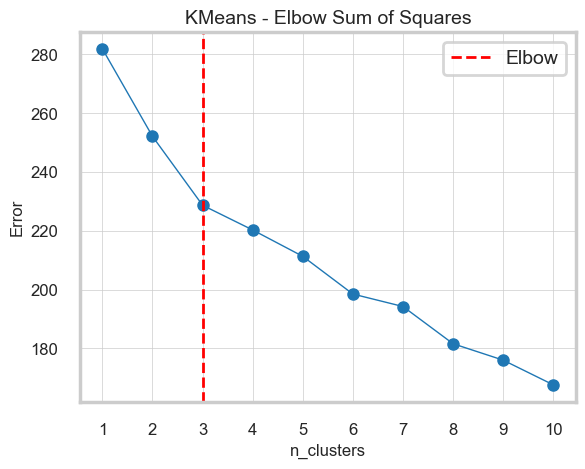

In [12]:
x = range(1,11)
y = sum_of_squares_data

plt.plot(x,y, marker = 'o', markersize = 8, linewidth = 1)
plt.grid(linewidth=0.5)

plt.axvline(x=3,color ='r', linestyle='--',linewidth = 2, label = 'Elbow')

plt.xticks(x)
plt.tick_params(axis='x', labelsize=12) 
plt.tick_params(axis='y', labelsize=12)

plt.xlabel('n_clusters', fontsize=12)
plt.ylabel('Error', fontsize=12)
plt.title('KMeans - Elbow Sum of Squares', fontsize=14)

plt.legend(fontsize=14)

plt.show()

Looks like the elbow is at 3 clusters. After that point we see the reduction in the sum of squares error
start decreasing more slowly. 

In [13]:
model_3_clusters = KMeans(n_clusters = 3,n_init = 'auto',random_state=42)
model_3_clusters.fit(x_cols)
labels = model_3_clusters.predict(x_cols)

label_count = np.bincount(labels)

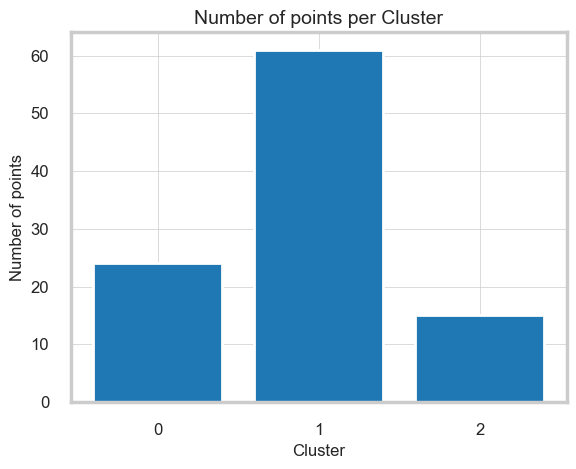

In [14]:
plt.bar([0,1,2], label_count, width=0.8, bottom=None, align='center')

plt.grid(linewidth=0.5)

plt.xticks([0,1,2])

plt.tick_params(axis='x', labelsize=12) 
plt.tick_params(axis='y', labelsize=12)

plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Number of points', fontsize=12)
plt.title('Number of points per Cluster', fontsize=14)

plt.show()

Cluster 1 is significantly larger than the others in terms of points. More than double. 

#### 3aii. Choosing K: The Silhouette Method

There exists another method that measures how well each datapoint $x_i$ "fits" its assigned cluster *and also* how poorly it fits into other clusters. This is a different way of looking at the same objective. Denote $a_{x_i}$ as the *average* distance from $x_i$ to all other points within its own cluster $k$. The lower the value, the better. On the other hand $b_{x_i}$ is the minimum average distance from $x_i$ to points in a different cluster, minimized over clusters. That is, compute separately for each cluster the average distance from $x_i$ to the points within that cluster, and then take the minimum. The silhouette $s(x_i)$ is defined as

$$s(x_i) = \frac{b_{x_i} - a_{x_i}}{\max{\left( a_{x_i}, b_{x_i}\right)}}$$

The silhouette score is computed on *every datapoint in every cluster*. The silhouette score ranges from -1 (a poor clustering) to +1 (a very dense clustering) with 0 denoting the situation where clusters overlap. Some criteria for the silhouette coefficient is provided in the table below.

<pre>

| Range       | Interpretation                                |
|-------------|-----------------------------------------------|
| 0.71 - 1.0  | A strong structure has been found.            |
| 0.51 - 0.7  | A reasonable structure has been found.        |
| 0.26 - 0.5  | The structure is weak and could be artificial.|
| < 0.25      | No substantial structure has been found.      |

</pre>
Source: http://www.stat.berkeley.edu/~spector/s133/Clus.html

**Hint**: Scikit-learn provides a function to compute this for us (phew!) called [`sklearn.metrics.silhouette_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html). Take a look at [this article](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) on picking $K$ in scikit-learn, as it will help you in the next exercise set.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set III</h3>

<p><b>Exercise:</b> Using the documentation for the `silhouette_score` function above, construct a series of silhouette plots like the ones in the article linked above.</p>

<p><b>Exercise:</b> Compute the average silhouette score for each $K$ and plot it. What $K$ does the plot suggest we should choose? Does it differ from what we found using the Elbow method?</p>
</div>

In [15]:
# Your turn.

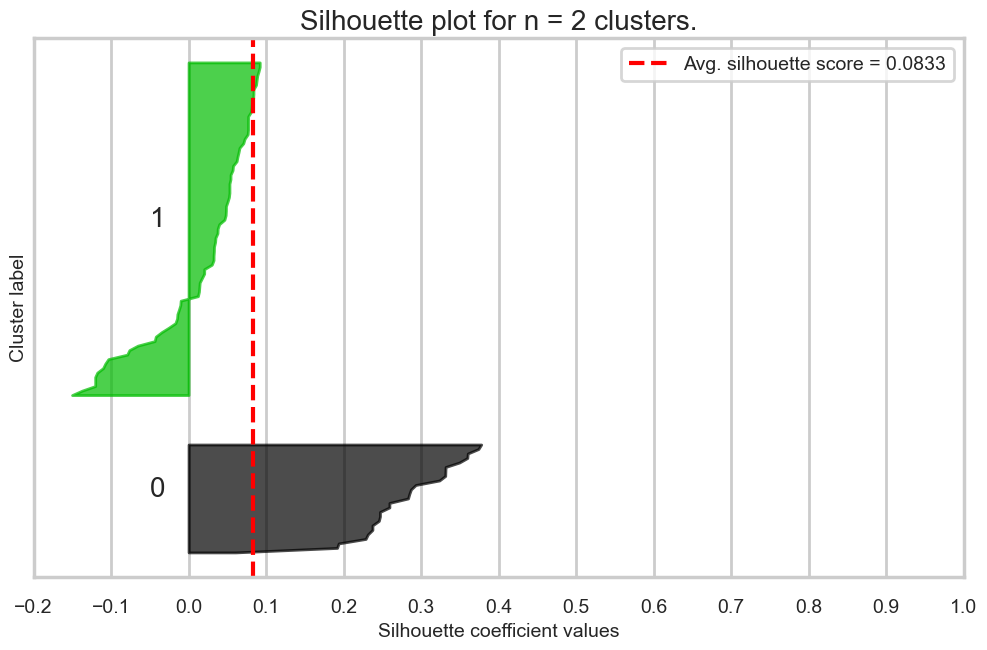

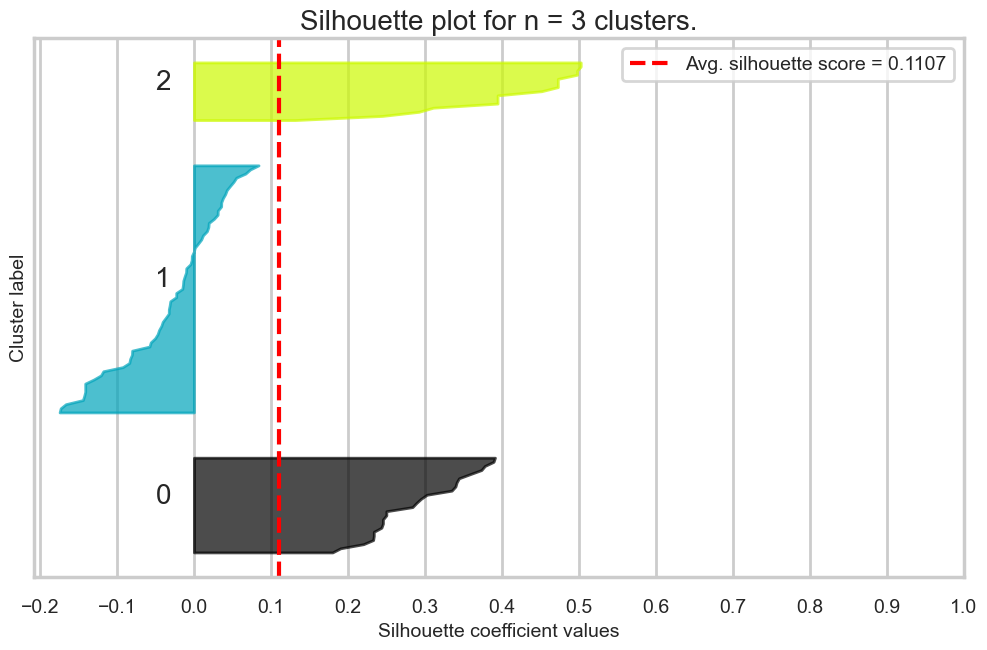

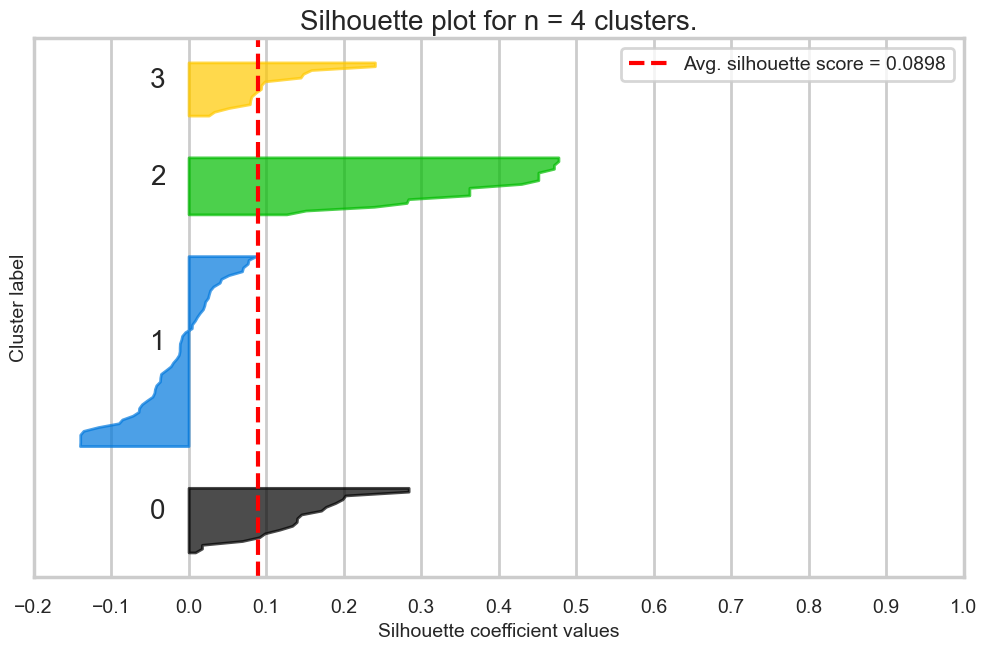

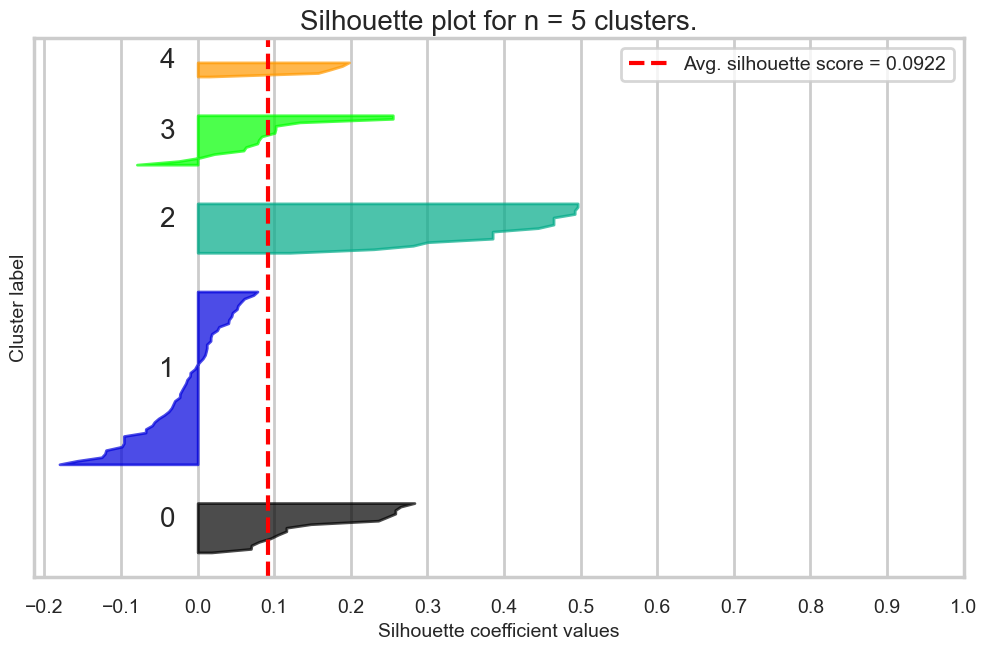

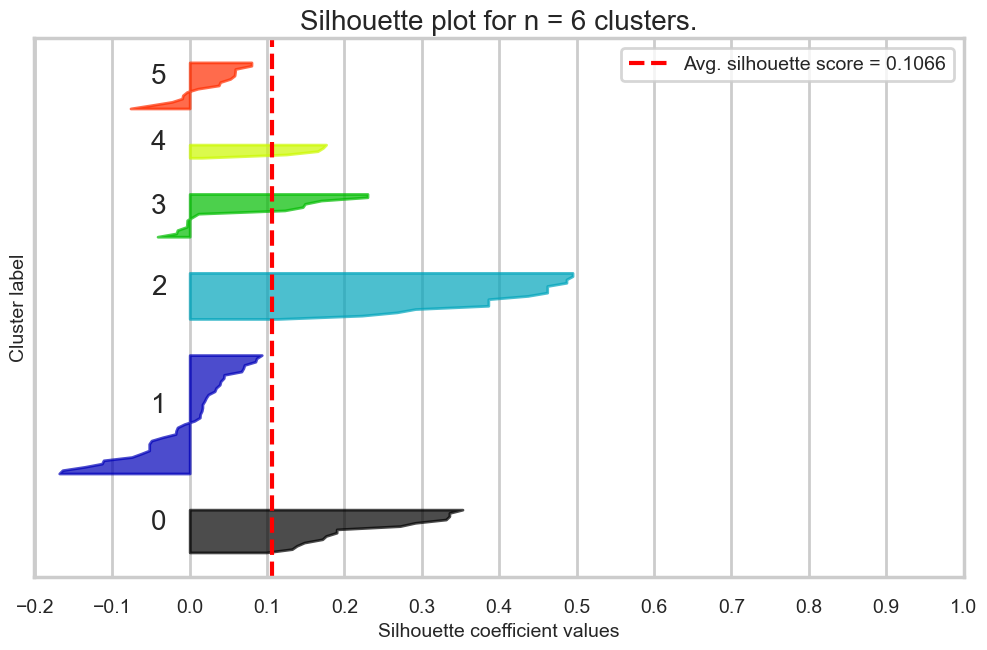

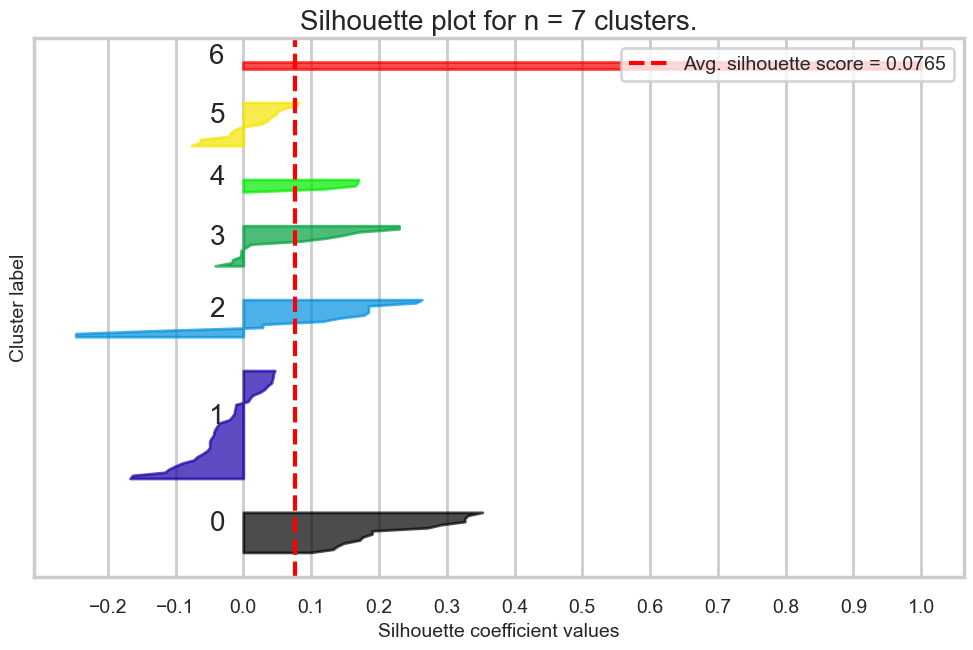

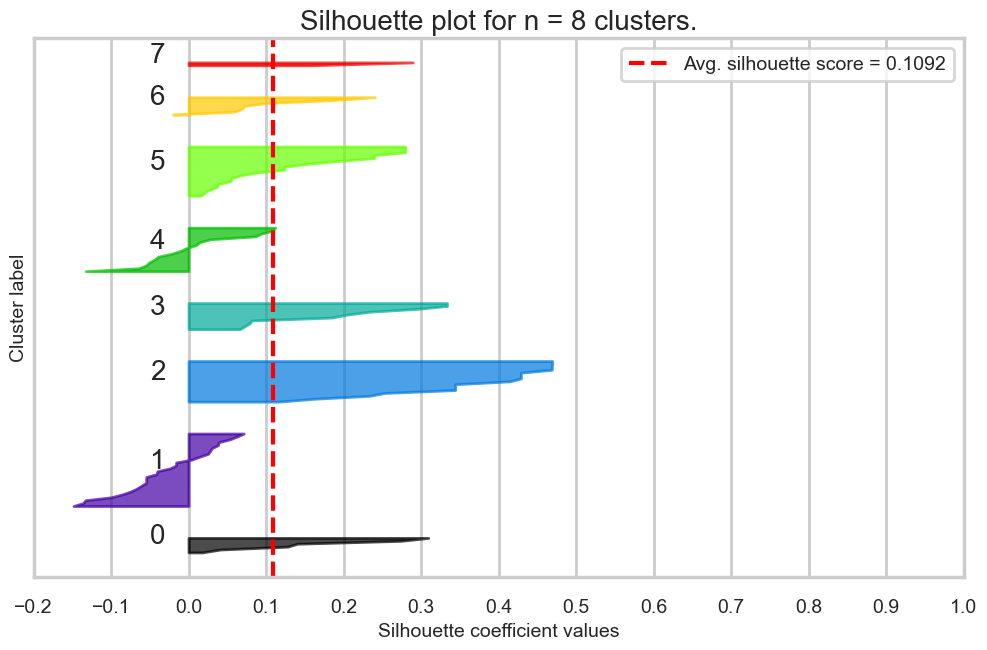

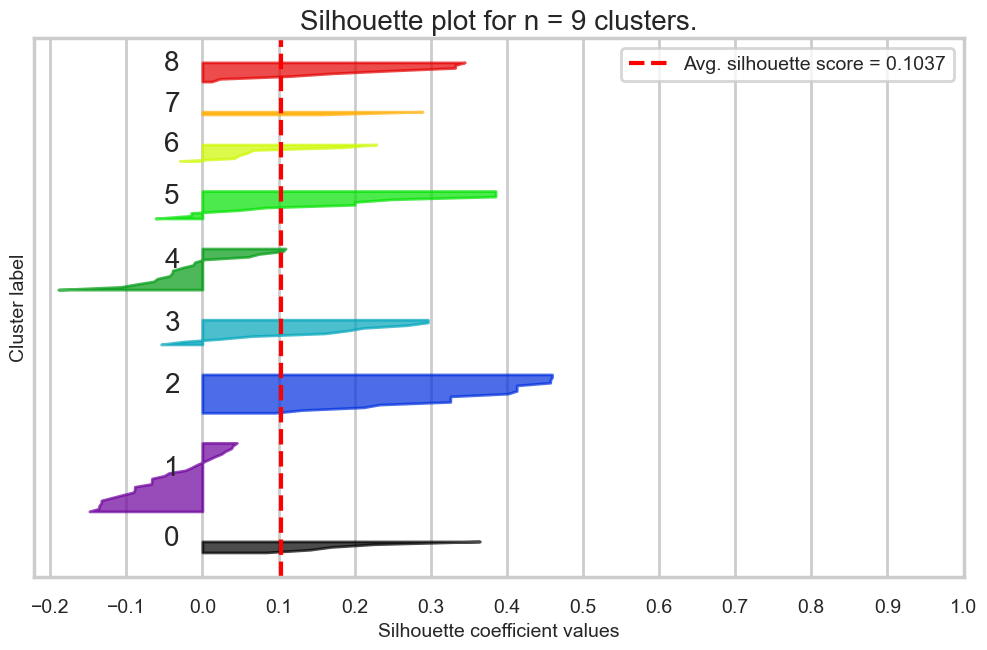

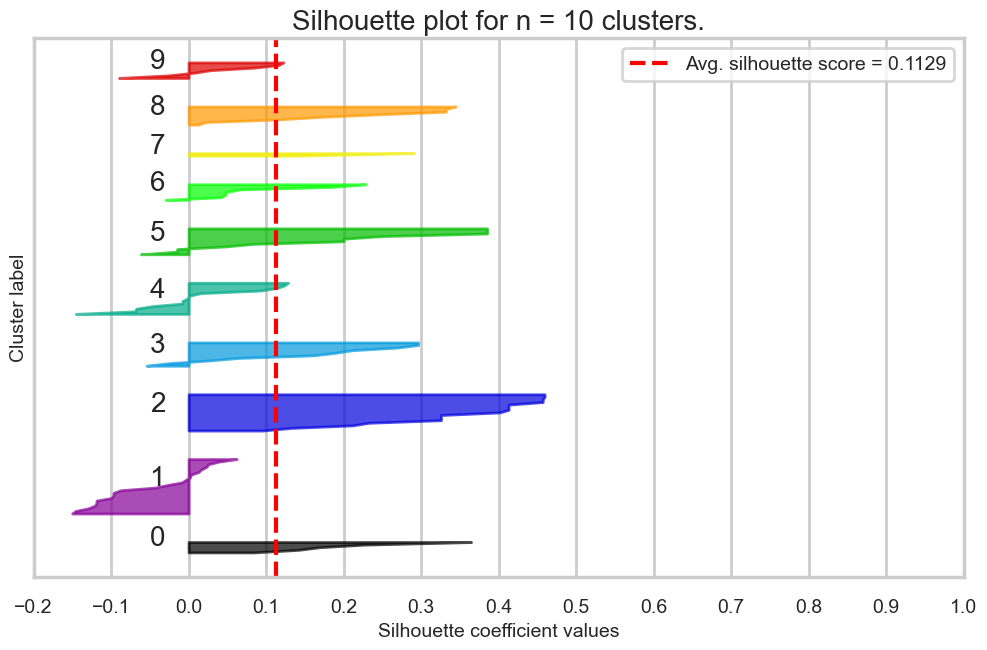

In [16]:
#Sillouette plots

range_n_clusters = range(2,11)

#range_n_clusters = [2, 3, 4, 5, 6,7,8,9,10]
silouette_avg_scores = []

for n_clusters in range_n_clusters:
    fig,ax1 = plt.subplots(figsize=(12, 7))
    
    clusterer = KMeans(n_clusters=n_clusters,n_init = 'auto' ,random_state=42)
    cluster_labels = clusterer.fit_predict(x_cols)


    silhouette_avg = silhouette_score(x_cols, cluster_labels)
    silouette_avg_scores.append(silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(x_cols, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i),fontsize=20)

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title(f"Silhouette plot for n = {n_clusters} clusters.",fontsize=20)
    ax1.set_xlabel("Silhouette coefficient values", fontsize=14)
    ax1.set_ylabel("Cluster label", fontsize=14)

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--", label=f'Avg. silhouette score = {round(silhouette_avg,4)}')

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    
    ax1.set_xticks([-0.2,-0.1, 0, 0.1 ,0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
    ax1.tick_params(axis = 'x', labelsize =14)
    ax1.tick_params(axis = 'y', labelsize =14)


    plt.legend(fontsize = 14)

    plt.show()

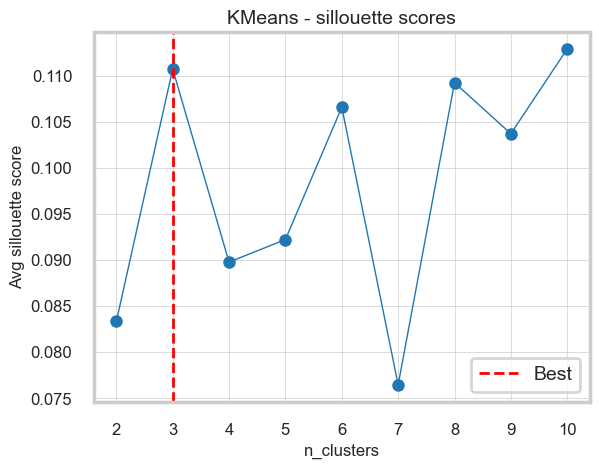

In [17]:
x = range(2,11)
y = silouette_avg_scores

plt.plot(x,y, marker = 'o', markersize = 8, linewidth = 1)
plt.grid(linewidth=0.5)

plt.axvline(x=3,color ='r', linestyle='--',linewidth = 2, label = 'Best')

plt.xticks(x)
plt.tick_params(axis='x', labelsize=12) 
plt.tick_params(axis='y', labelsize=12)

plt.xlabel('n_clusters', fontsize=12)
plt.ylabel('Avg sillouette score', fontsize=12)
plt.title('KMeans - sillouette scores', fontsize=14)

plt.legend(fontsize=14)

plt.show()

The Silouette method indicates either 3 or possibly 10 clusters as the best option.
The graph above indicates 3 since this matches with the Sum of Squares elbow method above, giving us two data points in favor of n = 3

The average sillouette scores for all the cluster options are very low. They are low enough that
on avarage you would say that there is no substantial structure. 

However, when you look at the individual plots above, some of the cluster scores are much higher
than the average, indicating at least weak structure. Cluster 2 in the three cluster plot was the
only cluster to really approach a silouette score of 0.5, indicating that that cluster at least had some structure. 

#### 3aiii.  Choosing $K$: The Gap Statistic

There is one last method worth covering for picking $K$, the so-called Gap statistic. The computation for the gap statistic builds on the sum-of-squares established in the Elbow method discussion, and compares it to the sum-of-squares of a "null distribution," that is, a random set of points with no clustering. The estimate for the optimal number of clusters $K$ is the value for which $\log{SS}$ falls the farthest below that of the reference distribution:

$$G_k = E_n^*\{\log SS_k\} - \log SS_k$$

In other words a good clustering yields a much larger difference between the reference distribution and the clustered data. The reference distribution is a Monte Carlo (randomization) procedure that constructs $B$ random distributions of points within the bounding box (limits) of the original data and then applies K-means to this synthetic distribution of data points.. $E_n^*\{\log SS_k\}$ is just the average $SS_k$ over all $B$ replicates. We then compute the standard deviation $\sigma_{SS}$ of the values of $SS_k$ computed from the $B$ replicates of the reference distribution and compute

$$s_k = \sqrt{1+1/B}\sigma_{SS}$$

Finally, we choose $K=k$ such that $G_k \geq G_{k+1} - s_{k+1}$.

#### Aside: Choosing $K$ when we Have Labels

Unsupervised learning expects that we do not have the labels. In some situations, we may wish to cluster data that is labeled. Computing the optimal number of clusters is much easier if we have access to labels. There are several methods available. We will not go into the math or details since it is rare to have access to the labels, but we provide the names and references of these measures.

* Adjusted Rand Index
* Mutual Information
* V-Measure
* Fowlkes–Mallows index

**Hint:** See [this article](http://scikit-learn.org/stable/modules/clustering.html) for more information about these metrics.

### 3b. Visualizing Clusters using PCA

How do we visualize clusters? If we only had two features, we could likely plot the data as is. But we have 100 data points each containing 32 features (dimensions). Principal Component Analysis (PCA) will help us reduce the dimensionality of our data from 32 to something lower. For a visualization on the coordinate plane, we will use 2 dimensions. In this exercise, we're going to use it to transform our multi-dimensional dataset into a 2 dimensional dataset.

This is only one use of PCA for dimension reduction. We can also use PCA when we want to perform regression but we have a set of highly correlated variables. PCA untangles these correlations into a smaller number of features/predictors all of which are orthogonal (not correlated). PCA is also used to reduce a large set of variables into a much smaller one.

**Hint:** PCA was discussed in the previous subunit. If you need help with it, consult [this useful article](https://towardsdatascience.com/a-one-stop-shop-for-principal-component-analysis-5582fb7e0a9c) and [this visual explanation](http://setosa.io/ev/principal-component-analysis/). 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set IV</h3>

<p><b>Exercise:</b> Use PCA to plot your clusters:</p>

<ul>
<li> Use scikit-learn's [`PCA`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) function to reduce the dimensionality of your clustering data to 2 components
<li> Create a data frame with the following fields:
  <ul>
  <li> customer name
  <li> cluster id the customer belongs to
  <li> the two PCA components (label them `x` and `y`)
  </ul>
<li> Plot a scatterplot of the `x` vs `y` columns
<li> Color-code points differently based on cluster ID
<li> How do the clusters look? 
<li> Based on what you see, what seems to be the best value for $K$? Moreover, which method of choosing $K$ seems to have produced the optimal result visually?
</ul>

<p><b>Exercise:</b> Now look at both the original raw data about the offers and transactions and look at the fitted clusters. Tell a story about the clusters in context of the original data. For example, do the clusters correspond to wine variants or something else interesting?</p>
</div>

In [18]:
#your turn
pca = PCA(n_components=2)
pca.fit(x_cols)
x_pca_transform = pca.transform(x_cols)

In [19]:
df_pca = pd.DataFrame()

df_pca['customer_name']= df_pivot.index
df_pca['cluster_label'] = labels
df_pca['x'] = x_pca_transform[:,0]
df_pca['y'] = x_pca_transform[:,1]


df_pca.head()

,customer_name,cluster_label,x,y
0,Adams,0,1.007580,0.108215
1,Allen,1,-0.287539,0.044715
2,Anderson,2,-0.392032,1.038391
3,Bailey,0,0.699477,-0.022542
4,Baker,1,0.088183,-0.471695


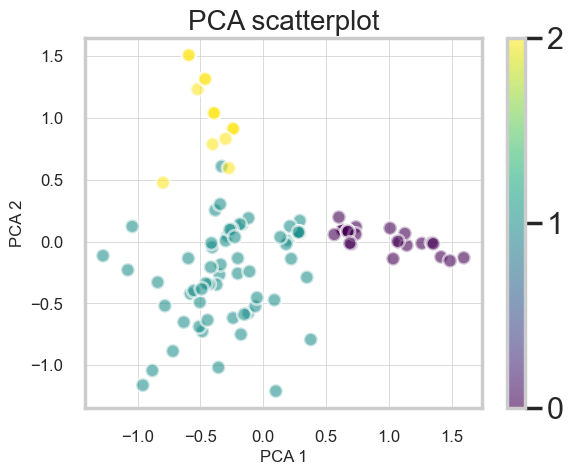

In [20]:
plt.scatter(df_pca['x'], df_pca['y'], c=df_pca['cluster_label'], cmap='viridis', s=100, alpha=0.6, edgecolors='w')

plt.grid(linewidth=0.5)

cbar = plt.colorbar()
cbar.set_ticks([0,1,2])


plt.xlabel('PCA 1',fontsize=12)
plt.ylabel('PCA 2',fontsize=12)
plt.title('PCA scatterplot', fontsize=20)

plt.tick_params(axis='x', labelsize=12) 
plt.tick_params(axis='y', labelsize=12)

plt.show()

K=3 seems to be a decent clustering for K. We can't tell just from this what the clusters mean though. 
For that we need to match up the original data from the offers to the clusters we see here. 

In [21]:
df_combined = df_pca.merge(df_transactions,on='customer_name')
df_combined = df_combined.merge(df_offers, on='offer_id')


In [22]:
df_combined.head()

,customer_name,cluster_label,x,y,offer_id,n,campaign,varietal,min_qty,discount,origin,past_peak
0,Adams,0,1.007580,0.108215,18,1,July,Espumante,6,50,Oregon,False
1,Adams,0,1.007580,0.108215,29,1,November,Pinot Grigio,6,87,France,False
2,Adams,0,1.007580,0.108215,30,1,December,Malbec,6,54,France,False
3,Allen,1,-0.287539,0.044715,9,1,April,Chardonnay,144,57,Chile,False
4,Allen,1,-0.287539,0.044715,27,1,October,Champagne,72,88,New Zealand,False


In [23]:
cluster_0_df = df_combined[df_combined['cluster_label']==0]
cluster_1_df = df_combined[df_combined['cluster_label']==1]
cluster_2_df = df_combined[df_combined['cluster_label']==2]

cluster_data = [cluster_0_df, cluster_1_df, cluster_2_df]

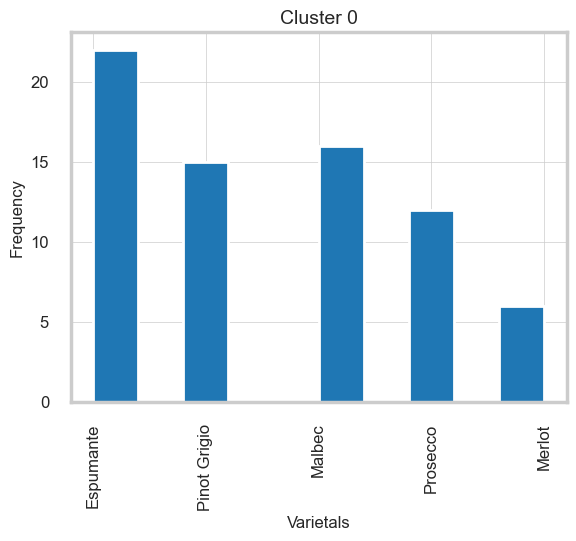

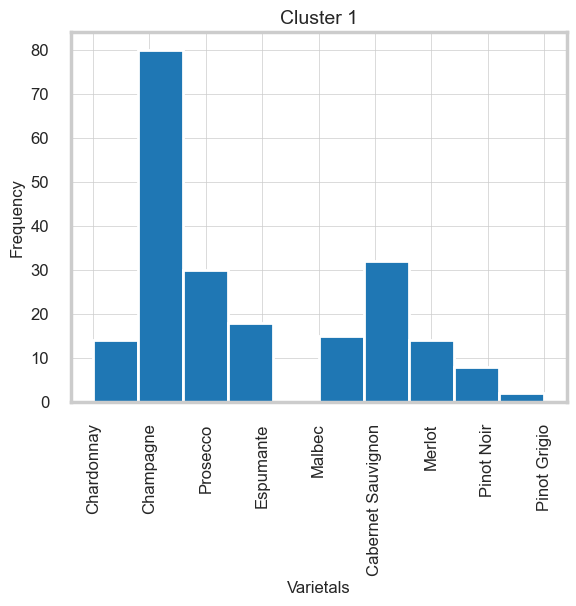

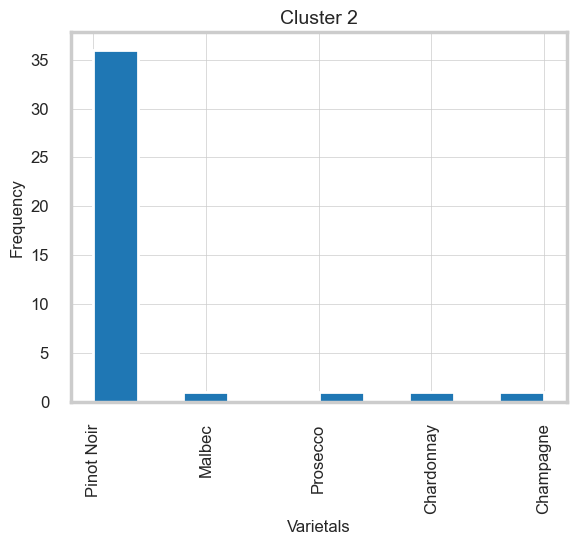

In [24]:
for item in cluster_data:
    plt.hist(item['varietal'])
    plt.grid(linewidth=0.5)

    plt.xticks(rotation=90)
    plt.tick_params(axis='x', labelsize=12) 
    plt.tick_params(axis='y', labelsize=12)

    plt.xlabel('Varietals', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.title('Cluster ' + str(item.cluster_label.unique()[0]), fontsize=14)

    #plt.legend(fontsize=14)
    plt.show()

Based on this rough analysis, it looks like the clusters coorespond to vine varietals.

Cluster_0
These customers buy a variety of wines, but they don't seem to like Pinot Noir, Champagne or Cabernet Sauvignon

Cluster_1
These customer buy a variety but really likes Champagne and Cabernet Sauvignon

Cluster_2
These customers really only buy pinot noir

What we've done is we've taken those columns of 0/1 indicator variables, and we've transformed them into a 2-D dataset. We took one column and arbitrarily called it `x` and then called the other `y`. Now we can throw each point into a scatterplot. We color coded each point based on it's cluster so it's easier to see them.

<div class="span5 alert alert-info">
<h3>Exercise Set V</h3>

<p>As we saw earlier, PCA has a lot of other uses. Since we wanted to visualize our data in 2 dimensions, restricted the number of dimensions to 2 in PCA. But what is the true optimal number of dimensions?</p>

<p><b>Exercise:</b> Using a new PCA object shown in the next cell, plot the `explained_variance_` field and look for the elbow point, the point where the curve's rate of descent seems to slow sharply. This value is one possible value for the optimal number of dimensions. What is it?</p>
</div>

In [25]:
#your turn
# Initialize a new PCA model with a default number of components.
import sklearn.decomposition
pca = sklearn.decomposition.PCA()
pca.fit(x_cols)

# Do the rest on your own :)


PCA()

In [26]:
explained_variance = pca.explained_variance_

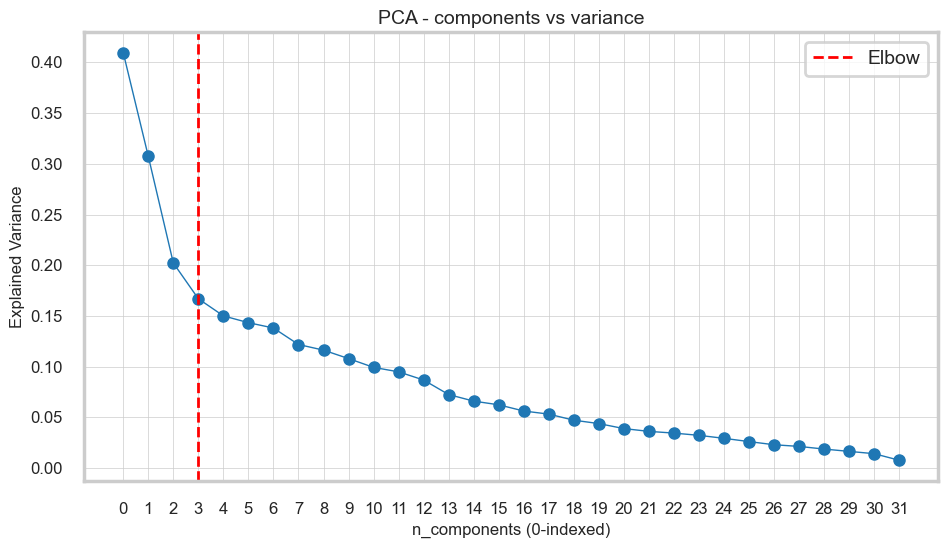

In [27]:
x = range(len(explained_variance ))
y = explained_variance

plt.figure(figsize=(10, 6))

plt.plot(x,y, marker = 'o', markersize = 8, linewidth = 1)
plt.grid(linewidth=0.5)

plt.axvline(x=3,color ='r', linestyle='--',linewidth = 2, label = 'Elbow')

plt.xticks(x)
plt.tick_params(axis='x', labelsize=12) 
plt.tick_params(axis='y', labelsize=12)

plt.xlabel('n_components (0-indexed)', fontsize=12)
plt.ylabel('Explained Variance', fontsize=12)
plt.title('PCA - components vs variance', fontsize=14)

plt.tight_layout()

plt.legend(fontsize=14)


plt.show()



## 4. Conclusions and next steps
### 4a. Conclusions
What can you conclude from your investigations? Make a note, formulate it as clearly as possible, and be prepared to discuss it with your mentor in your next call. 

Using three clusters and 2 PCA components allowed us to identify some clusters in the data that seemed relatively meaningful in terms of customer segmentation. 
However, the PCA component number vs variance plot above indicates that 4 components would have been a better fit than 2.
2 components is of course much easier to vizualize and captures about 75% of the variance
If I were to run the exersize again I would try n_components = 3, capturing 90+ percent of the variance while still retaining the ability
to make a plot in 3-d. 

Even without trying that additional step, I think the process here worked suprisingly well. 

### 4b. Other clustering algorithms

k-means is only one of a ton of clustering algorithms. Below is a brief description of several clustering algorithms, and the table provides references to the other clustering algorithms in scikit-learn. 

* **Affinity Propagation** does not require the number of clusters $K$ to be known in advance! AP uses a "message passing" paradigm to cluster points based on their similarity. 

* **Spectral Clustering** uses the eigenvalues of a similarity matrix to reduce the dimensionality of the data before clustering in a lower dimensional space. This is tangentially similar to what we did to visualize k-means clusters using PCA. The number of clusters must be known a priori.

* **Ward's Method** applies to hierarchical clustering. Hierarchical clustering algorithms take a set of data and successively divide the observations into more and more clusters at each layer of the hierarchy. Ward's method is used to determine when two clusters in the hierarchy should be combined into one. It is basically an extension of hierarchical clustering. Hierarchical clustering is *divisive*, that is, all observations are part of the same cluster at first, and at each successive iteration, the clusters are made smaller and smaller. With hierarchical clustering, a hierarchy is constructed, and there is not really the concept of "number of clusters." The number of clusters simply determines how low or how high in the hierarchy we reference and can be determined empirically or by looking at the [dendogram](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html).

* **Agglomerative Clustering** is similar to hierarchical clustering but but is not divisive, it is *agglomerative*. That is, every observation is placed into its own cluster and at each iteration or level or the hierarchy, observations are merged into fewer and fewer clusters until convergence. Similar to hierarchical clustering, the constructed hierarchy contains all possible numbers of clusters and it is up to the analyst to pick the number by reviewing statistics or the dendogram.

* **DBSCAN** is based on point density rather than distance. It groups together points with many nearby neighbors. DBSCAN is one of the most cited algorithms in the literature. It does not require knowing the number of clusters a priori, but does require specifying the neighborhood size.

### Clustering Algorithms in Scikit-learn
<table border="1">
<colgroup>
<col width="15%" />
<col width="16%" />
<col width="20%" />
<col width="27%" />
<col width="22%" />
</colgroup>
<thead valign="bottom">
<tr><th>Method name</th>
<th>Parameters</th>
<th>Scalability</th>
<th>Use Case</th>
<th>Geometry (metric used)</th>
</tr>
</thead>
<tbody valign="top">
<tr><td>K-Means</span></a></td>
<td>number of clusters</td>
<td>Very large<span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span> with
MiniBatch code</td>
<td>General-purpose, even cluster size, flat geometry, not too many clusters</td>
<td>Distances between points</td>
</tr>
<tr><td>Affinity propagation</td>
<td>damping, sample preference</td>
<td>Not scalable with n_samples</td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Mean-shift</td>
<td>bandwidth</td>
<td>Not scalable with <span class="pre">n_samples</span></td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Distances between points</td>
</tr>
<tr><td>Spectral clustering</td>
<td>number of clusters</td>
<td>Medium <span class="pre">n_samples</span>, small <span class="pre">n_clusters</span></td>
<td>Few clusters, even cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Ward hierarchical clustering</td>
<td>number of clusters</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints</td>
<td>Distances between points</td>
</tr>
<tr><td>Agglomerative clustering</td>
<td>number of clusters, linkage type, distance</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints, non Euclidean
distances</td>
<td>Any pairwise distance</td>
</tr>
<tr><td>DBSCAN</td>
<td>neighborhood size</td>
<td>Very large <span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span></td>
<td>Non-flat geometry, uneven cluster sizes</td>
<td>Distances between nearest points</td>
</tr>
<tr><td>Gaussian mixtures</td>
<td>many</td>
<td>Not scalable</td>
<td>Flat geometry, good for density estimation</td>
<td>Mahalanobis distances to  centers</td>
</tr>
<tr><td>Birch</td>
<td>branching factor, threshold, optional global clusterer.</td>
<td>Large <span class="pre">n_clusters</span> and <span class="pre">n_samples</span></td>
<td>Large dataset, outlier removal, data reduction.</td>
<td>Euclidean distance between points</td>
</tr>
</tbody>
</table>
Source: http://scikit-learn.org/stable/modules/clustering.html

<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Try clustering using the following algorithms. </p>
<ol>
<li>Affinity propagation
<li>Spectral clustering
<li>Agglomerative clustering
<li>DBSCAN
</ol>
<p>How do their results compare? Which performs the best? Tell a story why you think it performs the best.</p>
</div>


In [28]:
# Your turn

For each clustering algorithm below I'm going to use the same approach using PCA with 2 components to plot the data. 
I'll be reusing the PCA components that were already created for x_cols earlier in the notebook. 
This should ensure that the comparison is really between the results of the clustering algorithms, and it will provide 
an easy way to visualize the diffences on a 2-d plot

### Affinity Propagation

In [29]:
from sklearn.cluster import AffinityPropagation
from sklearn.metrics import pairwise_distances

In [30]:
similarity_matrix = pairwise_distances((np.array(x_cols)), metric ='euclidean')


affinity_propagation = AffinityPropagation(damping = 0.98, random_state=42)
affinity_propagation.fit(similarity_matrix)
cluster_centers_indices = affinity_propagation.cluster_centers_indices_
aff_labels = affinity_propagation.labels_

n_clusters = len(cluster_centers_indices)
print(f"Number of clusters: {n_clusters}")

Number of clusters: 6


In [31]:
df_combined_aff_prop = pd.DataFrame()

df_combined_aff_prop['customer_name']= df_pivot.index
df_combined_aff_prop['cluster_label'] = aff_labels
df_combined_aff_prop['x'] = x_pca_transform[:,0]
df_combined_aff_prop['y'] = x_pca_transform[:,1]


df_combined_aff_prop.head()


,customer_name,cluster_label,x,y
0,Adams,2,1.007580,0.108215
1,Allen,3,-0.287539,0.044715
2,Anderson,4,-0.392032,1.038391
3,Bailey,3,0.699477,-0.022542
4,Baker,1,0.088183,-0.471695


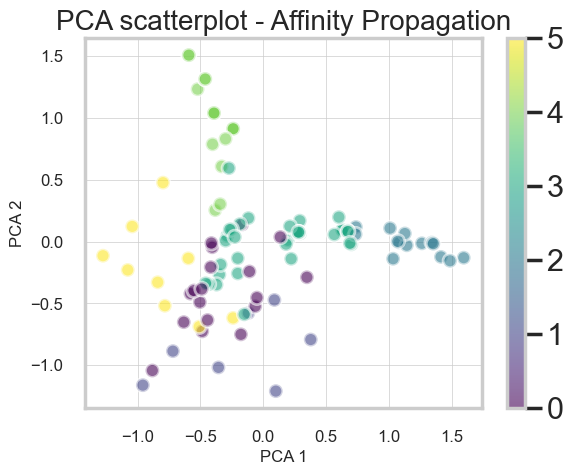

In [32]:
plt.scatter(df_combined_aff_prop['x'], df_combined_aff_prop['y'], c=df_combined_aff_prop['cluster_label'], cmap='viridis', s=100, alpha=0.6, edgecolors='w')

plt.grid(linewidth=0.5)

cbar = plt.colorbar()
cbar.set_ticks([0,1,2,3,4,5])


plt.xlabel('PCA 1',fontsize=12)
plt.ylabel('PCA 2',fontsize=12)
plt.title('PCA scatterplot - Affinity Propagation', fontsize=20)

plt.tick_params(axis='x', labelsize=12) 
plt.tick_params(axis='y', labelsize=12)

plt.show()

Really a mixed up plot here, at least when plotted in 2-d. 14 clusters seems like just too many for a data set this size.
There are only 32 offers. So this averages out to something like 2 offers per cluster. Not seeing this algorithm as having 
a lot of application for this particular dataset.  

### Spectral Clustering

Not sure how spectral clustering will perform, so I'm doing a rough graph of the silouette scores to see how
the clustering looks at various values of n_clusters. 

In [33]:
from sklearn.cluster import SpectralClustering

In [34]:
spec_array =np.array(x_cols) 

range_n_clusters = range(2,11)

silouette_avg_scores = []

for n_clusters in range_n_clusters:
    clusterer = SpectralClustering(n_clusters=n_clusters,random_state=42)
    cluster_labels = clusterer.fit_predict(spec_array)


    silhouette_avg = silhouette_score(spec_array, cluster_labels)
    silouette_avg_scores.append(silhouette_avg)


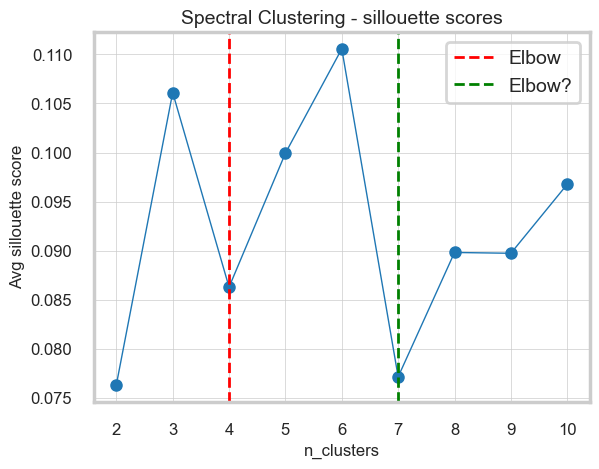

In [35]:
x = range(2,11)
y = silouette_avg_scores

plt.plot(x,y, marker = 'o', markersize = 8, linewidth = 1)
plt.grid(linewidth=0.5)

plt.axvline(x=4,color ='r', linestyle='--',linewidth = 2, label = 'Elbow')
plt.axvline(x=7,color ='g', linestyle='--',linewidth = 2, label = 'Elbow?')

plt.xticks(x)
plt.tick_params(axis='x', labelsize=12) 
plt.tick_params(axis='y', labelsize=12)

plt.xlabel('n_clusters', fontsize=12)
plt.ylabel('Avg sillouette score', fontsize=12)
plt.title('Spectral Clustering - sillouette scores', fontsize=14)

plt.legend(fontsize=14)

plt.show()

Looks like the typical elbow is at 4 clusters, but there there is a local minimum at 7, which is an interesting pattern.
I'm going to use 7 for the work below. 

In [36]:
spec_array =np.array(x_cols) 

spectral_clustering = SpectralClustering(n_clusters = 7, random_state=42)
spectral_labels = spectral_clustering.fit_predict(spec_array)



In [37]:
df_combined_spec = pd.DataFrame()

df_combined_spec['customer_name']= df_pivot.index
df_combined_spec['cluster_label'] = spectral_labels
df_combined_spec['x'] = x_pca_transform[:,0]
df_combined_spec['y'] = x_pca_transform[:,1]


df_combined_spec.head()

,customer_name,cluster_label,x,y
0,Adams,2,1.007580,0.108215
1,Allen,3,-0.287539,0.044715
2,Anderson,0,-0.392032,1.038391
3,Bailey,5,0.699477,-0.022542
4,Baker,3,0.088183,-0.471695


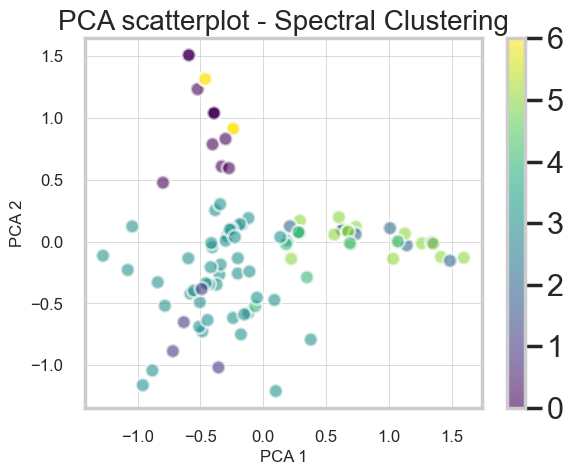

In [38]:
plt.scatter(df_combined_spec['x'], df_combined_spec['y'], c=df_combined_spec['cluster_label'], cmap='viridis', s=100, alpha=0.6, edgecolors='w')

plt.grid(linewidth=0.5)

cbar = plt.colorbar()
cbar.set_ticks([0,1,2,3,4,5,6])


plt.xlabel('PCA 1',fontsize=12)
plt.ylabel('PCA 2',fontsize=12)
plt.title('PCA scatterplot - Spectral Clustering', fontsize=20)

plt.tick_params(axis='x', labelsize=12) 
plt.tick_params(axis='y', labelsize=12)

plt.show()

A much more mixed picture here than with KMeans. This is with 7 clusters but 4 was tried as well and the results were the same. 

### Agglomerative clustering

In [39]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import linkage

In [40]:
agg_array =np.array(x_cols) 

In [41]:
clustering = AgglomerativeClustering(distance_threshold=0,n_clusters=None)
clustering.fit(agg_array)

print("Cluster labels:", clustering.labels_)


Cluster labels: [88 87 99 86 57 56 98 97 55 66 54 80 82 53 61 71 52 96 63 65 81 75 50 95
 90 69 51 89 72 40 84 62 83 43 60 77 25 85 67 70 47 91 93 76 59 64 49 26
 27 12 31 32 58 94 28 92 45 78 46 35 42 30 13 74 73 41 44 38 15 22 68 33
 48 34 37 23 36 29 24 18 21 14 20 17 79 39  8 19  9 10  6 16  4 11  5  2
  7  3  1  0]


In [42]:
Z = linkage(agg_array, method='ward')

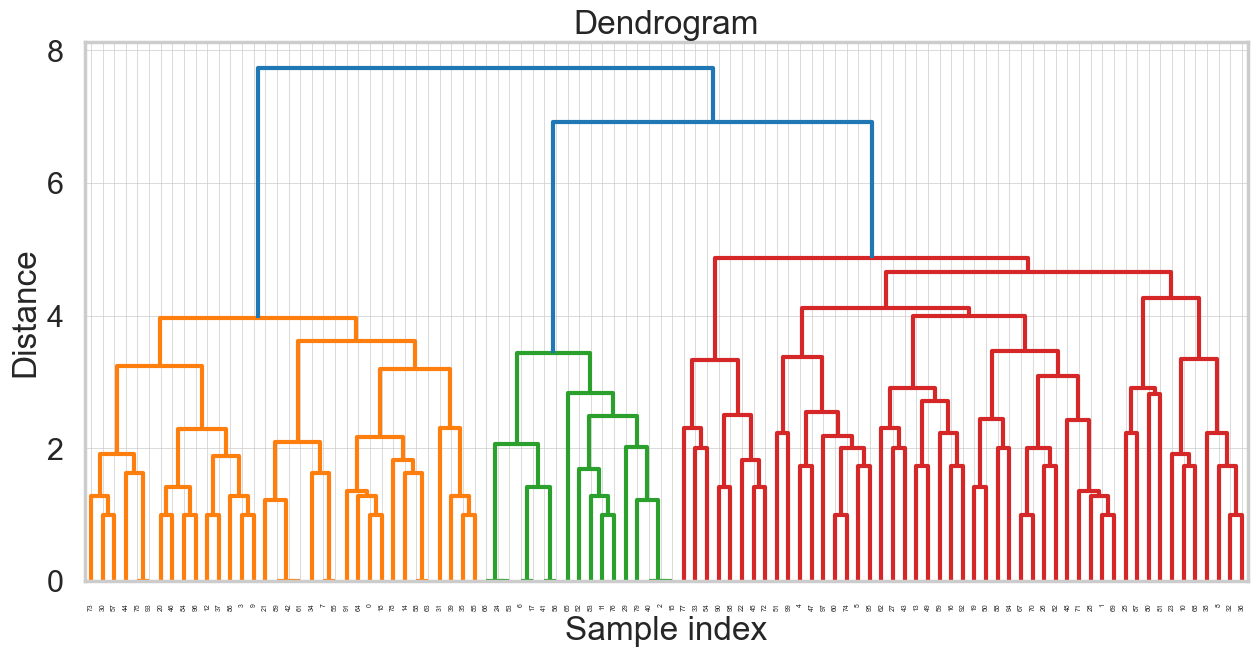

In [43]:
plt.figure(figsize=(15, 7))

plt.grid(linewidth=0.5)

plt.tick_params(axis='x', labelsize=12) 

plt.title("Dendrogram")
plt.xlabel("Sample index")
plt.ylabel("Distance")

dendrogram(Z)
plt.show()

In [44]:
cluster_labels = clustering.labels_ 
cluster_indices = {}

# Iterate over the unique cluster labels
for cluster_label in np.unique(cluster_labels):
    # Find indices of samples belonging to the current cluster
    indices = np.where(cluster_labels == cluster_label)[0]
    # Store the indices in the dictionary
    cluster_indices[cluster_label] = indices

# Print the dictionary containing indices for each cluster
print("Indices for samples in various groups:")
for cluster_label, indices in cluster_indices.items():
    print(f"Cluster {cluster_label}: {indices}")

Indices for samples in various groups:
Cluster 0: [99]
Cluster 1: [98]
Cluster 2: [95]
Cluster 3: [97]
Cluster 4: [92]
Cluster 5: [94]
Cluster 6: [90]
Cluster 7: [96]
Cluster 8: [86]
Cluster 9: [88]
Cluster 10: [89]
Cluster 11: [93]
Cluster 12: [49]
Cluster 13: [62]
Cluster 14: [81]
Cluster 15: [68]
Cluster 16: [91]
Cluster 17: [83]
Cluster 18: [79]
Cluster 19: [87]
Cluster 20: [82]
Cluster 21: [80]
Cluster 22: [69]
Cluster 23: [75]
Cluster 24: [78]
Cluster 25: [36]
Cluster 26: [47]
Cluster 27: [48]
Cluster 28: [54]
Cluster 29: [77]
Cluster 30: [61]
Cluster 31: [50]
Cluster 32: [51]
Cluster 33: [71]
Cluster 34: [73]
Cluster 35: [59]
Cluster 36: [76]
Cluster 37: [74]
Cluster 38: [67]
Cluster 39: [85]
Cluster 40: [29]
Cluster 41: [65]
Cluster 42: [60]
Cluster 43: [33]
Cluster 44: [66]
Cluster 45: [56]
Cluster 46: [58]
Cluster 47: [40]
Cluster 48: [72]
Cluster 49: [46]
Cluster 50: [22]
Cluster 51: [26]
Cluster 52: [16]
Cluster 53: [13]
Cluster 54: [10]
Cluster 55: [8]
Cluster 56: [5]
Clus

In [45]:
from scipy.cluster.hierarchy import fcluster

# Assuming you have performed hierarchical clustering and have the linkage matrix Z
# Also assuming you have a distance threshold `distance_threshold`

# Cut the dendrogram at the specified distance threshold to obtain upper-level clusters
upper_level_clusters = fcluster(Z, t=6, criterion='distance')

# Print the upper-level cluster labels
print("Upper-level cluster labels:", upper_level_clusters)

# Get indices for samples in various upper-level clusters
upper_level_cluster_indices = {}

# Iterate over the unique upper-level cluster labels
for cluster_label in np.unique(upper_level_clusters):
    # Find indices of samples belonging to the current upper-level cluster
    indices = np.where(upper_level_clusters == cluster_label)[0]
    # Store the indices in the dictionary
    upper_level_cluster_indices[cluster_label] = indices

# Print the dictionary containing indices for each upper-level cluster
print("Indices for samples in various upper-level clusters:")
for cluster_label, indices in upper_level_cluster_indices.items():
    print(f"Upper-level Cluster {cluster_label}: {indices}")

Upper-level cluster labels: [1 3 2 1 3 3 2 1 3 1 3 2 1 3 1 2 3 2 1 3 1 1 3 3 2 3 3 3 3 2 1 1 3 3 1 1 3
 1 3 1 2 2 1 3 1 3 1 3 3 3 3 3 2 2 3 1 2 1 1 3 3 1 3 1 1 2 2 3 3 3 3 3 3 1
 3 1 2 3 1 2 3 3 3 2 1 1 1 3 3 1 3 1 3 1 3 3 1 3 3 3]
Indices for samples in various upper-level clusters:
Upper-level Cluster 1: [ 0  3  7  9 12 14 18 20 21 30 31 34 35 37 39 42 44 46 55 57 58 61 63 64
 73 75 78 84 85 86 89 91 93 96]
Upper-level Cluster 2: [ 2  6 11 15 17 24 29 40 41 52 53 56 65 66 76 79 83]
Upper-level Cluster 3: [ 1  4  5  8 10 13 16 19 22 23 25 26 27 28 32 33 36 38 43 45 47 48 49 50
 51 54 59 60 62 67 68 69 70 71 72 74 77 80 81 82 87 88 90 92 94 95 97 98
 99]


In [46]:
upper_level_cluster_indices[1]

array([ 0,  3,  7,  9, 12, 14, 18, 20, 21, 30, 31, 34, 35, 37, 39, 42, 44,
       46, 55, 57, 58, 61, 63, 64, 73, 75, 78, 84, 85, 86, 89, 91, 93, 96])

In [47]:
df_agg = pd.DataFrame()

df_agg['customer_name']= df_pivot.index
df_agg['x'] = x_pca_transform[:,0]
df_agg['y'] = x_pca_transform[:,1]


df_agg.head()

,customer_name,x,y
0,Adams,1.007580,0.108215
1,Allen,-0.287539,0.044715
2,Anderson,-0.392032,1.038391
3,Bailey,0.699477,-0.022542
4,Baker,0.088183,-0.471695


In [48]:
for cluster_label, indices in upper_level_cluster_indices.items():
    df_agg.loc[indices, 'cluster_label'] = cluster_label


In [49]:
#plot these by the PCA components
#For all 3 clusters - add the labels to the sharded df - 
df_agg.head()


,customer_name,x,y,cluster_label
0,Adams,1.007580,0.108215,1.0
1,Allen,-0.287539,0.044715,3.0
2,Anderson,-0.392032,1.038391,2.0
3,Bailey,0.699477,-0.022542,1.0
4,Baker,0.088183,-0.471695,3.0


In [50]:
df_agg['cluster_label'].unique()

array([1., 3., 2.])

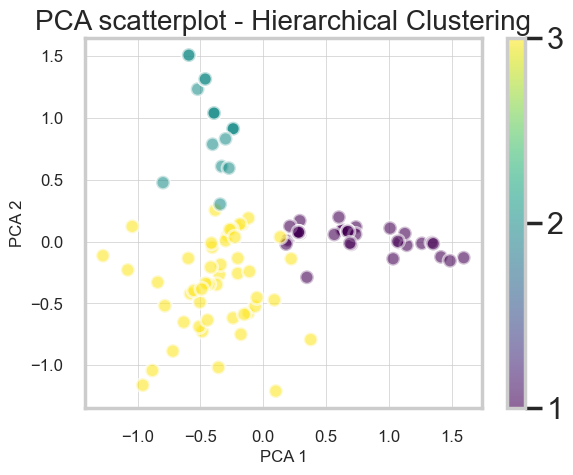

In [51]:
plt.scatter(df_agg['x'], df_agg['y'], c=df_agg['cluster_label'], cmap='viridis', s=100, alpha=0.6, edgecolors='w')

plt.grid(linewidth=0.5)

cbar = plt.colorbar()
cbar.set_ticks([1,2,3])


plt.xlabel('PCA 1',fontsize=12)
plt.ylabel('PCA 2',fontsize=12)
plt.title('PCA scatterplot - Hierarchical Clustering', fontsize=20)

plt.tick_params(axis='x', labelsize=12) 
plt.tick_params(axis='y', labelsize=12)

plt.show()

Very similar visually to the KMeans clustering earlier in the notebook. The dendrogram in for this algorithm is also interesting, 
but it's not clear really why a dendrogram adds much info to the data given the features and what we're trying to measure.
KMeans would provide a similar result to agglomerative clustering with less hassle. 

### DBSCAN

In [52]:
from sklearn.cluster import DBSCAN

In [53]:
dbscan_array = np.array(x_cols)

In [80]:
eps_value = []
noise_count = []
cluster_count = []

for i in np.arange(0.5,5,0.2):
    model= DBSCAN(eps = i, min_samples=4)
    model.fit(dbscan_array)

    
    dbscan_labels = pd.Series(model.labels_)
    
    
    non_noise_clusters = (dbscan_labels[dbscan_labels != -1].unique())
    print(non_noise_clusters)


    cluster_count.append(non_noise_clusters*10)
    
    count = dbscan_labels[dbscan_labels != -1].count()
    noise_count.append(count)
    eps_value.append(i)

[]
[]
[]
[0 2 1]
[0 2 1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]


In [57]:
print(cluster_count)

[0, 0, 0, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


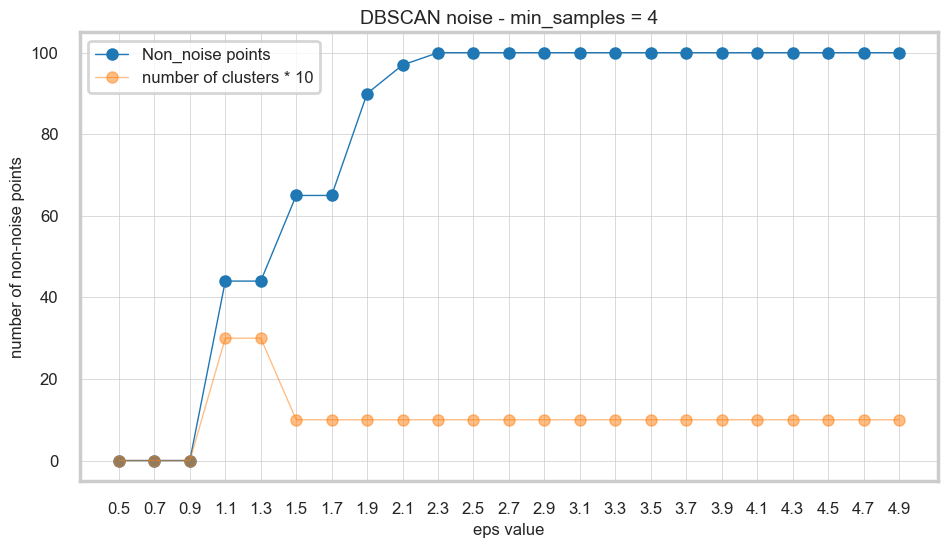

In [60]:
x = eps_value
y = noise_count

plt.figure(figsize=(10, 6))

plt.plot(x,y, marker = 'o', markersize = 8, linewidth = 1, label = 'Non_noise points')
plt.plot(x, cluster_count ,marker = 'o', markersize = 8, alpha = 0.5, linewidth = 1, label = 'number of clusters * 10')
plt.grid(linewidth=0.5)

#plt.axvline(x=3,color ='r', linestyle='--',linewidth = 2, label = 'Elbow')

plt.xticks(x)
plt.tick_params(axis='x', labelsize=12) 
plt.tick_params(axis='y', labelsize=12)

plt.xlabel('eps value', fontsize=12)
plt.ylabel('number of non-noise points', fontsize=12)
plt.title('DBSCAN noise - min_samples = 4', fontsize=14)

plt.legend(fontsize=12)
plt.tight_layout()

plt.show()

Pretty interesting results here. We see that the number of clusters is 0 early on - everything is noise
Then the number of clusters jumps to 3 (not counting noise), with about 45 non-noise points - or 45% of the total because we have 100 points in the array
As eps increases, the number of non-noise points increases, indicating that the neighborhoods are bigger. But there is only 1 cluster,
so everything is just being thrown together. 

We'll complete the model with an eps of 1.3

In [88]:
model= DBSCAN(eps = 1.3, min_samples=4)
model.fit(dbscan_array)

labels = model.labels_

In [89]:
print(labels)

[ 0  2  1  0 -1 -1  1  0 -1  0 -1  1  0 -1 -1  1 -1  1  0 -1  0  0 -1 -1
  1 -1 -1 -1  2 -1  0 -1 -1 -1 -1 -1 -1  0 -1 -1  1  1  0 -1 -1 -1  0 -1
 -1 -1 -1 -1 -1  1 -1  0  1  0  0 -1 -1  0 -1  0  0 -1  1 -1 -1  2 -1  2
 -1  0 -1  0  1 -1 -1  1 -1 -1 -1  1  0 -1  0 -1 -1  0 -1  0 -1  0 -1 -1
  0 -1 -1 -1]


In [94]:
dbscan_combined = pd.DataFrame()

dbscan_combined['customer_name']= df_pivot.index
dbscan_combined['cluster_label'] = labels
dbscan_combined['x'] = x_pca_transform[:,0]
dbscan_combined['y'] = x_pca_transform[:,1]


dbscan_combined.head()

,customer_name,cluster_label,x,y
0,Adams,0,1.007580,0.108215
1,Allen,2,-0.287539,0.044715
2,Anderson,1,-0.392032,1.038391
3,Bailey,0,0.699477,-0.022542
4,Baker,-1,0.088183,-0.471695


In [91]:
dbscan_combined['cluster_label'].unique()

array([ 0,  2,  1, -1])

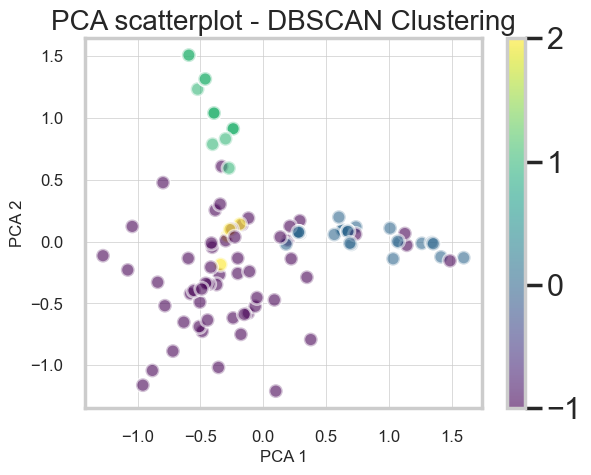

In [93]:
plt.scatter(dbscan_combined['x'], dbscan_combined['y'], c=dbscan_combined['cluster_label'], cmap='viridis', s=100, alpha=0.6, edgecolors='w')

plt.grid(linewidth=0.5)

cbar = plt.colorbar()
cbar.set_ticks([-1,0,1,2])


plt.xlabel('PCA 1',fontsize=12)
plt.ylabel('PCA 2',fontsize=12)
plt.title('PCA scatterplot - DBSCAN Clustering', fontsize=20)

plt.tick_params(axis='x', labelsize=12) 
plt.tick_params(axis='y', labelsize=12)

plt.show()

The -1 cluster here is being interpreted by the algortithm as noisy points - or points that are not considered part of a cluster. 
The eps value used showed the best performance based on what I could see, still not great. 
I don't think the data is dense enough for DBSCAN to be the right clustering algorithm. It looks dense with just the two PCA components plotted above, 
but really the DBSCAN model is being fit to the data itself, which has 32 features, and is pretty spare. We wouldn't expect much density. 
DBSCAN is an interesting algorithm, but it's not a good fit for this data I don't think. 


Overall hierarchical clustering worked the best on this data aside from KMeans. Both gave about the same clusterings when viewed in PCA.
Those clusters provided decent insights into the customer segmentation from the wine list by showing which varietal preferences tend to group together. 
That insight could have been obtained from either the KMeans or the Hierarchical clustering algorithms in combination with PCA. 

The other algorithms were interesting, but did not seem to be a good fit for the data set and problem at hand. 